I recognize that I can predict batting average the way Savant does using batted ball data, but I wanted to see if I could train an accurate model
based purely on pitch data and swing path along with some other features (all pre contact) and use that to find batters that will preform well off
specific pitchers. I can then translate that to run production, idk long term goal I suppose

In [2]:

import pandas as pd
import pybaseball
pybaseball.cache.enable()
print(pd.__version__)
from pybaseball import statcast
balldata = statcast(start_dt='2025-01-01',end_dt='2025-07-24')
balldata = pd.DataFrame(balldata)
from sklearn.model_selection import train_test_split as tts
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np

2.3.1
This is a large query, it may take a moment to complete
Skipping offseason dates


 92%|█████████▏| 122/132 [00:03<00:00, 48.20it/s]/sciclone/home/tdfelton/.conda/envs/baseball2/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|██████████| 132/132 [00:03<00:00, 33.13it/s]
/sciclone/home/tdfelton/.conda/envs/baseball2/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [3]:
balldata = pd.DataFrame(balldata)
balldata = balldata[balldata['game_type'] == 'R']
balldata.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
707,SL,2025-07-24,89.2,-1.78,5.93,"Miller, Mason",572138,695243,field_out,hit_into_play,...,<NA>,3.05,-0.62,0.62,<NA>,5.616837,0.272117,28.593004,44.091704,24.709678
714,CH,2025-07-24,94.7,-1.99,5.87,"Miller, Mason",572138,695243,NaN,blocked_ball,...,<NA>,2.29,1.34,-1.34,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
733,SL,2025-07-24,89.8,-1.64,6.09,"Miller, Mason",572138,695243,NaN,foul,...,<NA>,3.03,-0.82,0.82,<NA>,22.045201,-24.986198,24.437439,33.983367,35.776704
773,SL,2025-07-24,89.8,-1.76,6.04,"Miller, Mason",572138,695243,NaN,ball,...,<NA>,3.02,-0.56,0.56,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
774,SL,2025-07-24,90.3,-1.75,6.0,"Miller, Mason",572138,695243,NaN,foul,...,<NA>,2.75,-0.85,0.85,<NA>,21.524638,-42.976901,25.381468,32.916707,45.318534


In [4]:
populated_columns = balldata.columns[balldata.notna().any()].tolist()
balldata = balldata[populated_columns]
# Keep only rows where 'des' does NOT contain 'James Wood'
wood = balldata[balldata['des'].astype(str).str.contains("James Wood", case=False, na=False)]
wood = pd.DataFrame(wood)
wood.shape

(3403, 110)

Dropping the columns that don't have anything to do with batting average or are redundant or outdated
This means any variables that occur after the fact, hit type, description etc
Also dropped variables that happen semi randomly throughout the game like runners on base, the score, things that if you
are given an entire season will occur many times. Simulating batting average against a specific pitcher has to encompass all types of game situation, like innings, runners on, outs, stuff like that.

In [5]:
hits = ['single','double','triple','home_run']
lineups_y = balldata['events'].isin(hits).astype(int)
lineups_y.describe()
lineups_x = balldata.drop(columns=['events'])
lineups_x = lineups_x.drop(
    columns=[col for col in lineups_x.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col]
)

# Drop specific additional columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score','bat_win_dif'
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp','bat_score','fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b','pitch_name','home_score','away_score','description',
    'hit_location','bb_type','hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','delta_home_win_exp'
]
lineups_x = lineups_x.drop(columns=[col for col in cols_to_drop if col in lineups_x.columns])
print(lineups_x.shape,lineups_y.shape)
lineups_x.head()

(448579, 67) (448579,)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
707,SL,2025-07-24,89.2,-1.78,5.93,572138,695243,4,L,R,...,<NA>,3.05,-0.62,0.62,<NA>,5.616837,0.272117,28.593004,44.091704,24.709678
714,CH,2025-07-24,94.7,-1.99,5.87,572138,695243,14,L,R,...,<NA>,2.29,1.34,-1.34,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
733,SL,2025-07-24,89.8,-1.64,6.09,572138,695243,6,L,R,...,<NA>,3.03,-0.82,0.82,<NA>,22.045201,-24.986198,24.437439,33.983367,35.776704
773,SL,2025-07-24,89.8,-1.76,6.04,572138,695243,13,L,R,...,<NA>,3.02,-0.56,0.56,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
774,SL,2025-07-24,90.3,-1.75,6.0,572138,695243,6,L,R,...,<NA>,2.75,-0.85,0.85,<NA>,21.524638,-42.976901,25.381468,32.916707,45.318534


Split the date column into separate variables for improved accuracy

In [6]:
lineups_x['game_year'] = pd.to_datetime(lineups_x['game_date']).dt.year
lineups_x['game_month'] = pd.to_datetime(lineups_x['game_date']).dt.month
lineups_x['game_day'] = pd.to_datetime(lineups_x['game_date']).dt.day
# Then drop the original datetime column
lineups_x = lineups_x.drop(columns=['game_date','game_day'])


Translated all the categorical columns to strings as to avoid giving too much weight to something like the day (30th) or player ID 8192141 etc

In [7]:
categorical_cols = ['game_year','game_month','pitch_type','batter','pitcher','stand','p_throws',
                    'balls','strikes','inning','inning_topbot','game_pk','fielder_2',
                    'fielder_3','fielder_4','fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','pitch_number',
                    'at_bat_number','if_fielding_alignment','of_fielding_alignment','age_pit','age_bat','n_thruorder_pitcher',
                    'n_priorpa_thisgame_player_at_bat','pitcher_days_since_prev_game','batter_days_since_prev_game',
                    'pitcher_days_until_next_game','batter_days_until_next_game']
# See which categorical columns are missing from the DataFrame


lineups_x[categorical_cols] = lineups_x[categorical_cols].astype(str)

In [8]:
x_feat_train, x_feat_test, y_feat_train, y_feat_test = tts(lineups_x, lineups_y, test_size = 0.2)
model = CatBoostClassifier(verbose=100)
model.fit(x_feat_train,y_feat_train,cat_features=categorical_cols)

Learning rate set to 0.127025
0:	learn: 0.3804000	total: 137ms	remaining: 2m 16s
100:	learn: 0.1103123	total: 9.66s	remaining: 1m 25s
200:	learn: 0.1027908	total: 18.6s	remaining: 1m 13s
300:	learn: 0.0963382	total: 28.4s	remaining: 1m 5s
400:	learn: 0.0920168	total: 38.9s	remaining: 58s
500:	learn: 0.0892187	total: 49.2s	remaining: 49s
600:	learn: 0.0867095	total: 59.6s	remaining: 39.6s
700:	learn: 0.0845903	total: 1m 9s	remaining: 29.5s
800:	learn: 0.0824600	total: 1m 18s	remaining: 19.6s
900:	learn: 0.0805496	total: 1m 28s	remaining: 9.69s
999:	learn: 0.0789679	total: 1m 37s	remaining: 0us


Next the goal is to find the most important features to predicting batting average

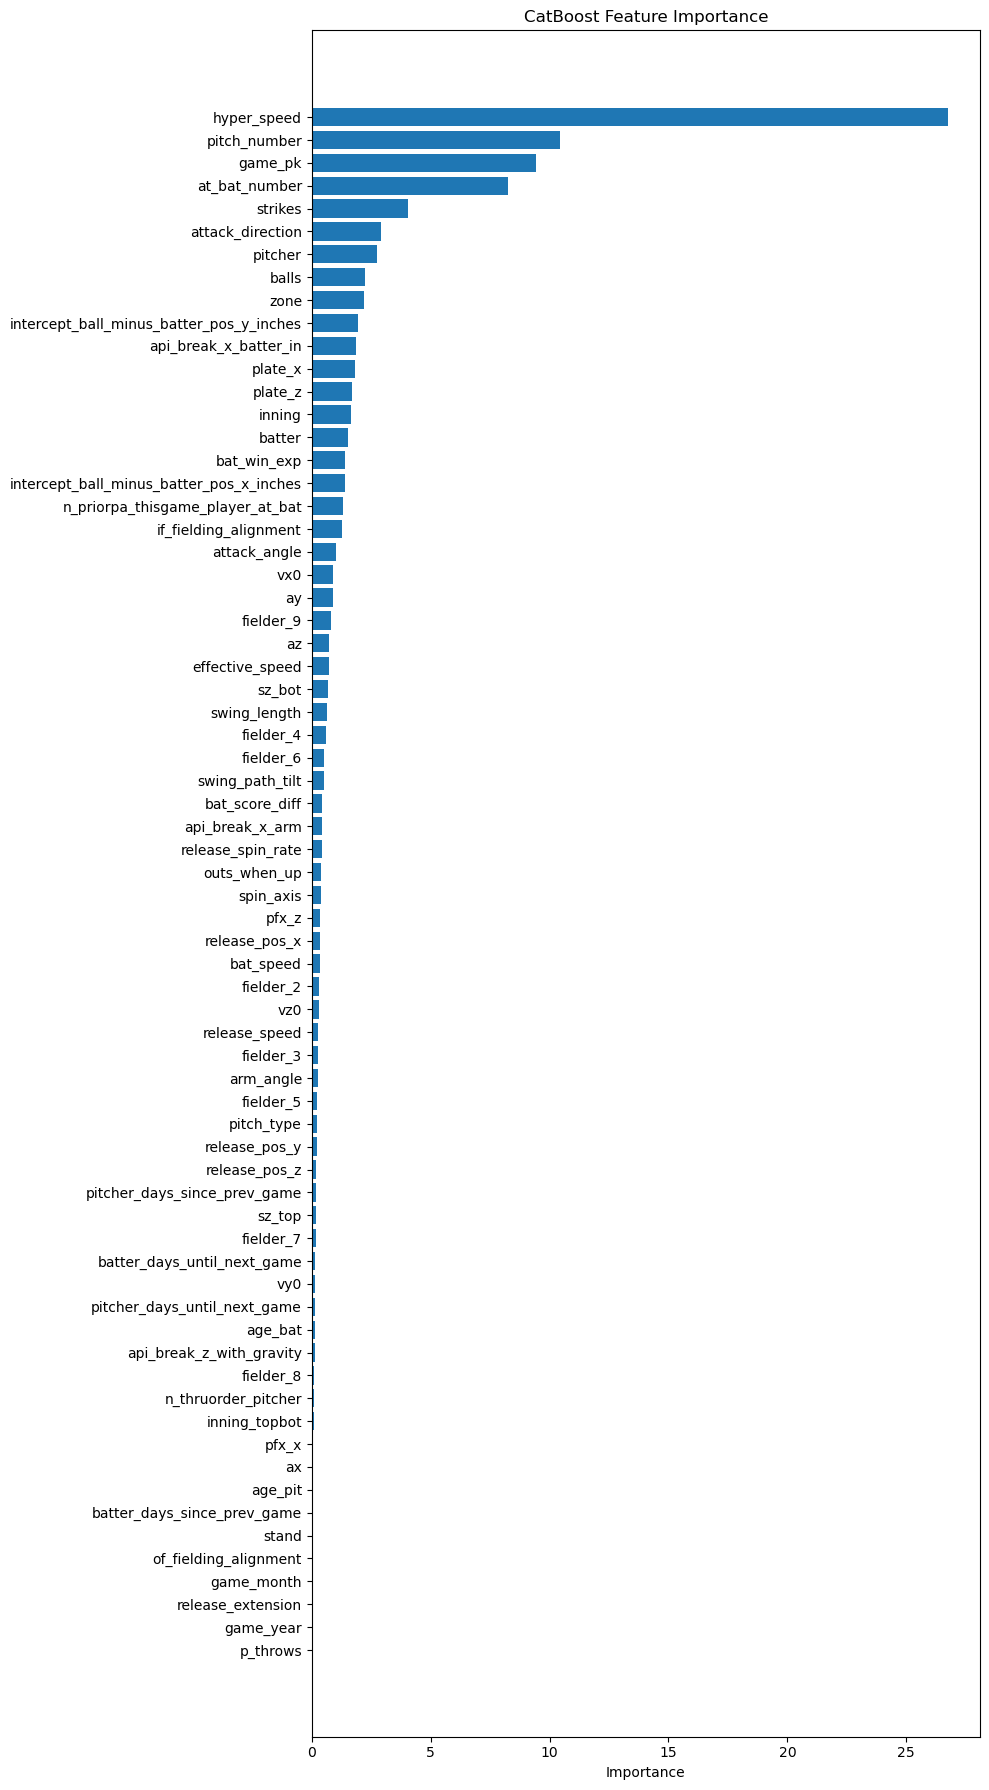

In [9]:
importances = model.get_feature_importance()
features = x_feat_train.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 18))
plt.barh(np.array(features)[indices], np.array(importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/sciclone/home/tdfelton/baseball/feature_selection_plots/all_mlb.png')
plt.show()

I can't find anything online to figure out what hyper_speed is but it seems to be important
Pretty sure p_throws effects batting average so I will include it in a more refined data pass, same with stand
of_fielding_alignment probably hsa something to do with BA too...
Not sure if this model was the best choice, going to try to run one on a specific batter.
James Wood is my favorite hitter so I will attempt him next.
Current idea is to cross reference the two feature importances and see what happens, hopefully something that makes more sense than this

In [10]:
james_wood = balldata[balldata['des'].astype(str).str.contains("James Wood", case=False, na=False)]
james_wood = pd.DataFrame(wood)
james_wood.shape

(3403, 110)

In [11]:
hits = ['single','double','triple','home_run']
wood_y = james_wood['events'].isin(hits).astype(int)
wood_x = james_wood.drop(columns=['events'])
wood_x = wood_x.drop(
    columns=[col for col in wood_x.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col]
)

# Drop specific additional columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score','bat_win_dif'
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp','bat_score','fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b','pitch_name','home_score','away_score','description',
    'hit_location','bb_type','hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','delta_home_win_exp'
]
wood_x = wood_x.drop(columns=[col for col in cols_to_drop if col in wood_x.columns])
print(wood_x.shape,wood_y.shape)
wood_x.head()

(3403, 67) (3403,)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
19,CU,2025-07-23,82.3,3.52,5.51,695578,666157,13,L,L,...,<NA>,3.06,-0.8,-0.8,<NA>,26.398117,-10.901361,43.526849,44.073135,45.802377
24,CU,2025-07-23,81.9,3.49,5.54,695578,666157,13,L,L,...,<NA>,3.15,-0.83,-0.83,<NA>,29.670511,-12.867122,38.956494,58.663642,42.498326
26,CU,2025-07-23,81.5,3.73,5.59,695578,666157,6,L,L,...,<NA>,3.26,-0.69,-0.69,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2748,SL,2025-07-23,83.5,-1.54,6.41,669720,691251,9,R,R,...,<NA>,3.11,-0.32,-0.32,<NA>,15.327239,-2.739369,28.925831,40.229664,38.832984
2827,SL,2025-07-23,86.8,-1.49,6.33,669720,691251,14,R,R,...,<NA>,2.78,-0.14,-0.14,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [12]:
wood_x['game_year'] = pd.to_datetime(wood_x['game_date']).dt.year
wood_x['game_month'] = pd.to_datetime(wood_x['game_date']).dt.month
wood_x['game_day'] = pd.to_datetime(wood_x['game_date']).dt.day
# Then drop the original datetime column

In [13]:
categorical_cols = ['game_month','pitch_type','batter','pitcher','stand','p_throws',
                    'balls','strikes','inning','inning_topbot','game_pk','fielder_2',
                    'fielder_3','fielder_4','fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','pitch_number',
                    'at_bat_number','if_fielding_alignment','of_fielding_alignment','age_pit','age_bat','n_thruorder_pitcher',
                    'n_priorpa_thisgame_player_at_bat','pitcher_days_since_prev_game','batter_days_since_prev_game',
                    'pitcher_days_until_next_game','batter_days_until_next_game']
# See which categorical columns are missing from the DataFrame


wood_x[categorical_cols] = wood_x[categorical_cols].astype(str)

In [14]:
x_wood_train, x_wood_test, y_wood_train, y_wood_test = tts(wood_x, wood_y, test_size = 0.2)
wood_model = CatBoostClassifier(verbose=100)
wood_model.fit(x_wood_train,y_wood_train,cat_features=categorical_cols)

Learning rate set to 0.015799
0:	learn: 0.6713883	total: 5.42ms	remaining: 5.41s
100:	learn: 0.1811800	total: 1.22s	remaining: 10.8s
200:	learn: 0.1403926	total: 2.66s	remaining: 10.6s
300:	learn: 0.1241632	total: 4.02s	remaining: 9.35s
400:	learn: 0.1104163	total: 5.44s	remaining: 8.12s
500:	learn: 0.0977399	total: 6.86s	remaining: 6.83s
600:	learn: 0.0866857	total: 8.29s	remaining: 5.5s
700:	learn: 0.0779865	total: 9.73s	remaining: 4.15s
800:	learn: 0.0698440	total: 11.2s	remaining: 2.77s
900:	learn: 0.0630778	total: 12.6s	remaining: 1.38s
999:	learn: 0.0575342	total: 14s	remaining: 0us


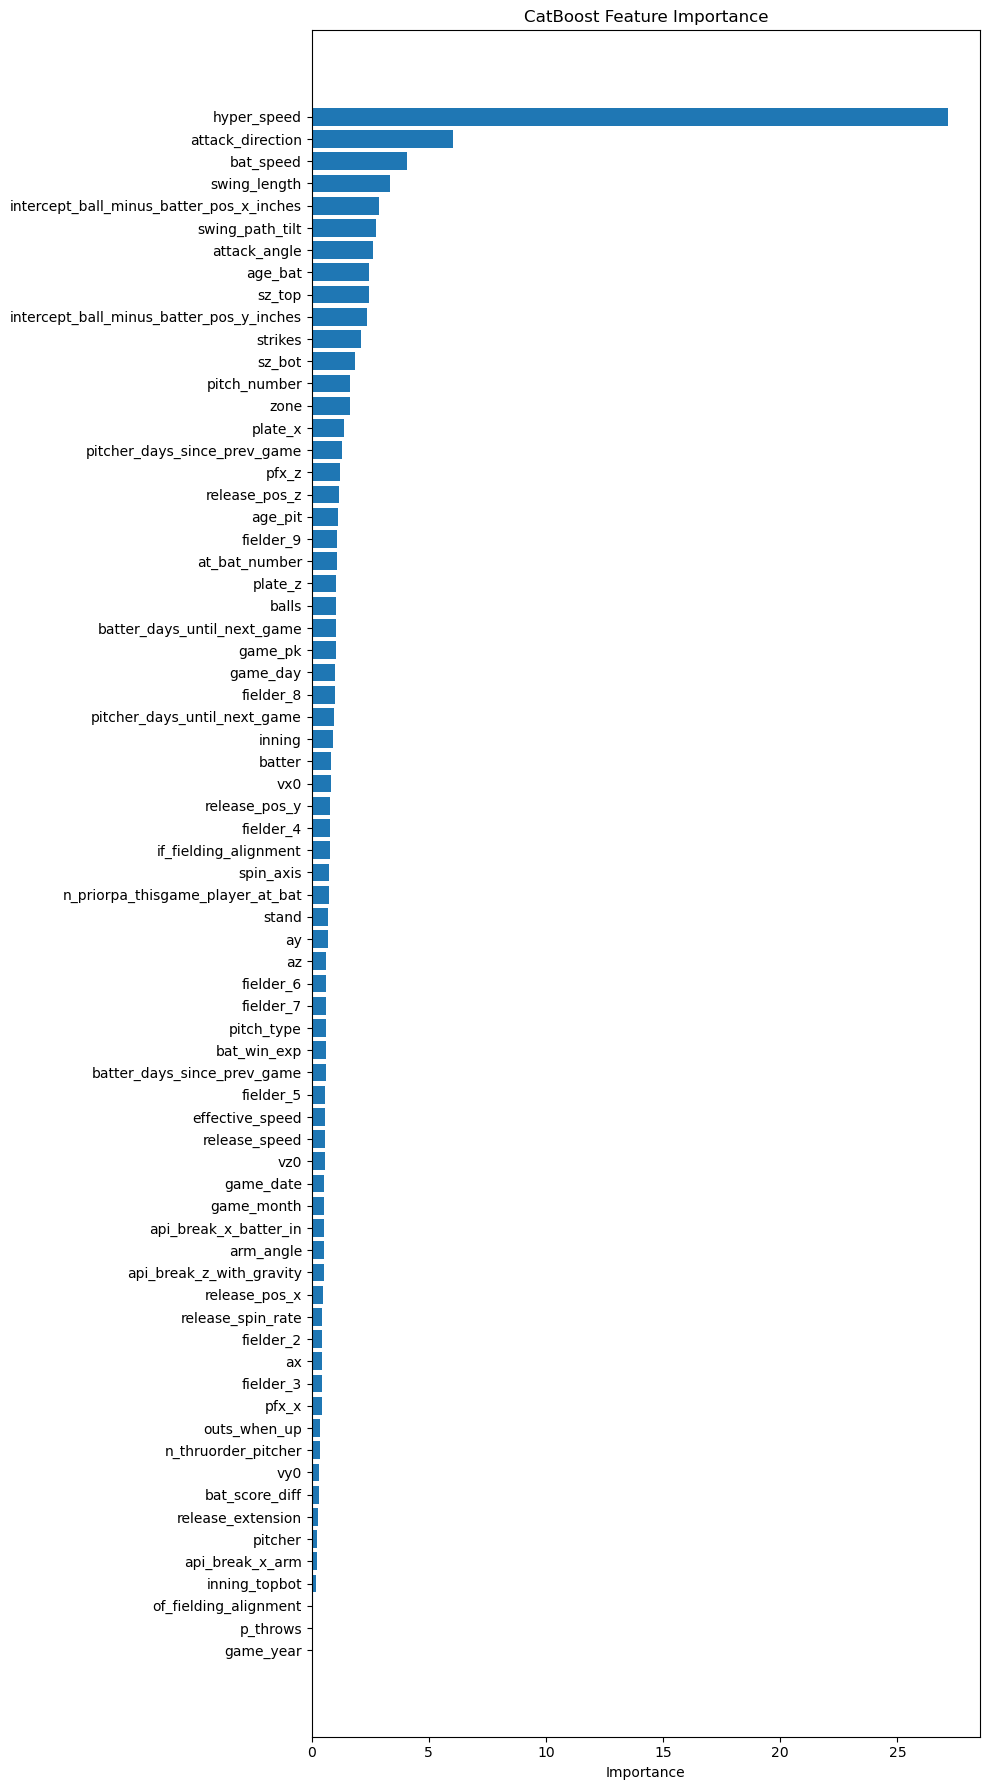

In [15]:
importances = wood_model.get_feature_importance()
features = x_wood_train.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 18))
plt.barh(np.array(features)[indices], np.array(importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/sciclone/home/tdfelton/baseball/feature_selection_plots/james_wood.png')
plt.show()

This makes no sense, except.... I still don't know what hyper_speed is! 
Considering dropping it because I think it's results based instead of prepitch/pitch location/ movement etc

I'm going to run this on a few more players with/without hyperspeed and see what the trends are. 

Training the model batter by batter is probably the right approach imo because every hitter has their own unique approach to hitting like swing path speed hotzones etc

New plan: going to make it so I can easily train the model on specific players just by changing one variable input

In [23]:
player = 'CJ Abrams'
player_data = balldata[balldata['des'].astype(str).str.contains(f"{player}", case=False, na=False)]
player_data = pd.DataFrame(player_data)
player_data.shape

(2958, 110)

In [24]:
hits = ['single','double','triple','home_run']
player_y = player_data['events'].isin(hits).astype(int)
player_x = player_data.drop(columns=['events'])
player_x = player_x.drop(
    columns=[col for col in player_x.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col]
)

# Drop specific additional columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score','bat_win_dif'
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp','bat_score','fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b','pitch_name','home_score','away_score','description',
    'hit_location','bb_type','hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','delta_home_win_exp'
]
player_x = player_x.drop(columns=[col for col in cols_to_drop if col in player_x.columns])
print(player_x.shape,player_y.shape)
player_x.head()

(2958, 67) (2958,)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
34,FF,2025-07-23,93.9,3.58,5.44,682928,666157,5,L,L,...,<NA>,1.99,1.52,1.52,<NA>,6.73725,5.450239,25.77651,41.663311,24.166665
45,FF,2025-07-23,93.8,3.63,5.44,682928,666157,13,L,L,...,<NA>,1.86,1.6,1.6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3384,FF,2025-07-23,91.7,-1.75,6.5,682829,691251,7,L,R,...,<NA>,1.91,1.18,-1.18,<NA>,-3.596437,14.705822,34.46181,41.965717,25.947003
3483,FF,2025-07-23,92.4,-1.72,6.46,682829,691251,13,L,R,...,<NA>,1.77,1.17,-1.17,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3670,SL,2025-07-23,86.1,2.71,5.71,670770,663455,7,L,L,...,<NA>,2.91,-0.12,-0.12,<NA>,-2.472843,1.353178,32.007484,41.405702,35.390621


In [25]:
player_x['game_year'] = pd.to_datetime(player_x['game_date']).dt.year
player_x['game_month'] = pd.to_datetime(player_x['game_date']).dt.month
player_x['game_day'] = pd.to_datetime(player_x['game_date']).dt.day
# Then drop the original datetime column

In [26]:
categorical_cols = ['game_month','pitch_type','batter','pitcher','stand','p_throws',
                    'balls','strikes','inning','inning_topbot','game_pk','fielder_2',
                    'fielder_3','fielder_4','fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','pitch_number',
                    'at_bat_number','if_fielding_alignment','of_fielding_alignment','age_pit','age_bat','n_thruorder_pitcher',
                    'n_priorpa_thisgame_player_at_bat','pitcher_days_since_prev_game','batter_days_since_prev_game',
                    'pitcher_days_until_next_game','batter_days_until_next_game']
# See which categorical columns are missing from the DataFrame


player_x[categorical_cols] = player_x[categorical_cols].astype(str)

In [27]:
x_play_train, x_play_test, y_play_train, y_play_test = tts(player_x, player_y, test_size = 0.2)
player_model = CatBoostClassifier(verbose=100)
player_model.fit(x_play_train,y_play_train,cat_features=categorical_cols)

Learning rate set to 0.014881
0:	learn: 0.6695598	total: 14.8ms	remaining: 14.8s
100:	learn: 0.1690595	total: 1.18s	remaining: 10.5s
200:	learn: 0.1265256	total: 2.58s	remaining: 10.3s
300:	learn: 0.1105175	total: 3.95s	remaining: 9.18s
400:	learn: 0.0984775	total: 5.34s	remaining: 7.99s
500:	learn: 0.0884591	total: 6.77s	remaining: 6.74s
600:	learn: 0.0796588	total: 8.2s	remaining: 5.44s
700:	learn: 0.0707874	total: 9.68s	remaining: 4.13s
800:	learn: 0.0631871	total: 11.1s	remaining: 2.76s
900:	learn: 0.0568506	total: 12.6s	remaining: 1.38s
999:	learn: 0.0514621	total: 14s	remaining: 0us


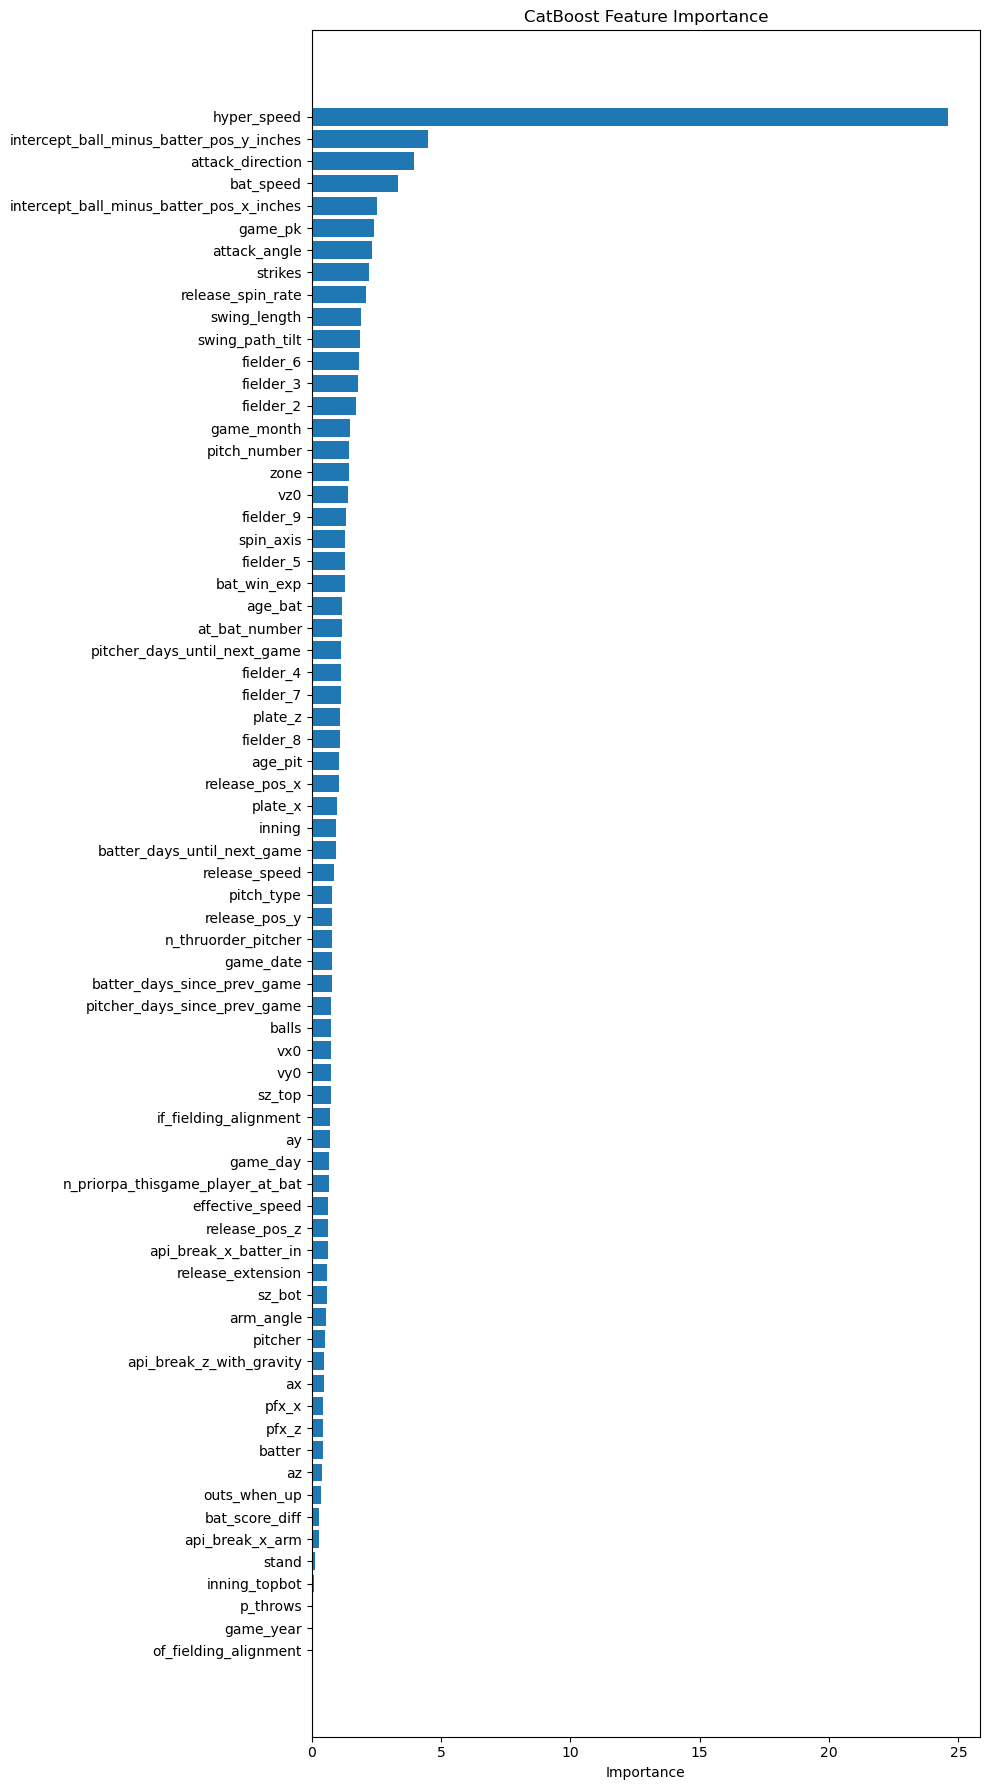

In [28]:
importances = player_model.get_feature_importance()
features = x_play_train.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 18))
plt.barh(np.array(features)[indices], np.array(importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'/sciclone/home/tdfelton/baseball/feature_selection_plots/{player.lower().replace(" ","_")}.png')
plt.show()

The hyper_speed variable is too closely related to batting average, this makes me think it is directly calculated using hits or something along those lines without knowing what it is or how it's calculated I cannot ethically use it in my calculations. This may decrease accuracy, but I think it increases the legitamacy of my code